# Exploring the Relationships Between SAT Scores and a Variety of Demographic Factors

## Table of Contents

1. [**Introduction**](#introduction)
	- Project Description
    - Data Description
    - Read In the Data
2. [**Data Cleaning**](#data_cleaning)
    - Add DBN Columns
    - Convert Columns to Numeric
    - Condense Columns
    - Combine the Data
    - Applying School Rating to Schools
3. [**Data Analysis & Visualization**](#analysis)
    - Exploring the Relationship Between SAT Scores and Survey Columns
    - Exploring the Relationship Between SAT Scores and Various Demographic Factors
    - Exploring the Relationship Between SAT Scores and the Percentage of Students Taking the AP Test
    - Finding Good Schools in Each Borough
4. [**Conclusion**](#conclusion)

<a id='introduction'></a>
# Introduction

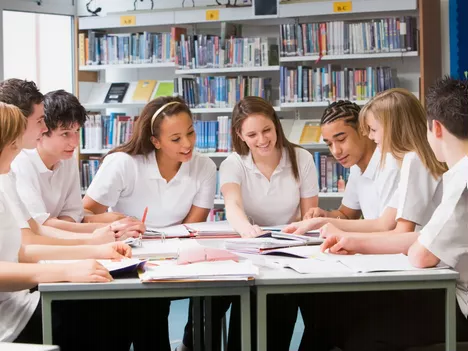

One of the most controversial issues in the U.S. educational system is the efficacy of standardized tests and whether they're unfair to certain groups. Our goal is to examine the correlation between SAT scores and other factors such as race, gender, etc.

### Data Description

New York City makes its [data on high school SAT scores](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4) available online, as well as the [demographics for each high school.](https://data.cityofnewyork.us/Education/2014-2015-DOE-High-School-Directory/n3p6-zve2) We are also going to use the following datasets:

* [School attendance](https://data.cityofnewyork.us/Education/2010-2011-School-Attendance-and-Enrollment-Statist/7z8d-msnt) - Attendance information for each school in New York City.
* [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) - Information on class size for each school.
* [AP test results](https://data.cityofnewyork.us/Education/2010-AP-College-Board-School-Level-Results/itfs-ms3e) - Advanced Placement exam results for each high school.
* [Graduation outcomes](https://data.cityofnewyork.us/Education/2005-2010-Graduation-Outcomes-School-Level/vh2h-md7a) - The percentage of students who graduated, and other outcome information.
* [School survey](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8) - Surveys of parents, teachers, and students at each school.

These datasets will help us achieve our goal.

## Read In the Data

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
import re

# Visualizations
import matplotlib.pyplot as plt
import matplotlib.style as style
%matplotlib inline

Let's start by reading in the files we will be using during this project.

In [2]:
# Store all file names in a list
data_files = ["ap_2010.csv",
              "class_size.csv",
              "demographics.csv",
              "graduation.csv",
              "hs_directory.csv",
              "sat_results.csv"]

# Create new dictionary to store data files
data = dict()

# Add dataframes to `data` dictionary using file name without `.csv` as key
for f in data_files:
    data[f[:-4]] = pd.read_csv(f'data/{f}')

We have 2 more files. There are a lot of redundant columns in these 2 files. We should read in these files and leave only the necessary columns.

In [3]:
# Read in survey files and merge them together
all_survey = pd.read_csv('data/survey_all.txt', delimiter='\t', encoding='windows-1252')
d75_survey = pd.read_csv('data/survey_d75.txt', delimiter='\t', encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0).copy()

# Create new column `DBN` with `dbn` column values
survey['DBN'] = survey['dbn']

# List for mapping
survey_cols = ["DBN", "rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", "com_p_11", "eng_p_11",
        "aca_p_11", "saf_t_11", "com_t_11", "eng_t_11", "aca_t_11", "saf_s_11", "com_s_11",
        "eng_s_11", "aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11"]

# Use `survey_cols` as map to remove redundant columns
survey = survey[survey_cols]
data['survey'] = survey

<a id='data_cleaning'></a>
# Data Cleaning

## Add DBN Columns

Some of our data doesn't have `DBN` column. We will fix that in this section.

In [4]:
# Create new column `DBN` with `dbn` column values
data['hs_directory']['DBN'] = data['hs_directory']['dbn']

def padding(val):
    """
    Return modified value based on condition
    Check if value is less than 2 or not
    If True return value with zero in the beginning as string
    If False return value
    """
    if len(str(val)) < 2:
        return str(val).zfill(2)
    else:
        return val

# Applying padding() to CSD
data['class_size']['padded_csd'] = data['class_size']['CSD'].apply(padding)
# Create `DBN` column using `padded_csd` and `SCHOOL CODE` columns
data['class_size']['DBN'] = data['class_size']['padded_csd'].astype(str) + data['class_size']['SCHOOL CODE']

## Convert Columns to Numeric

Many numeric columns in our data have the wrong `datatype`. We will change this in this section.

In [5]:
# Columns for different SAT scores
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']

# Convert values in each SAT score column to numeric
for c in cols:
    data['sat_results'][c] = pd.to_numeric(data['sat_results'][c], errors='coerce')

# Sum three `sat_results` to one `sat_score`.
data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def get_lat(s):
    '''
    Function returns latitude
    Look for coordinates in a string, split the coords by `,` and remmove `(`
    '''
    coords = re.findall(r'\(.+\)', s)
    lat = coords[0].split(', ')[0].replace('(', '')
    return lat

def get_lon(s):
    '''
    Function returns longitude
    Look for coordinates in a string, split the coords by `,` and remmove `)`
    '''
    coords = re.findall(r'\(.+\)', s)
    lon = coords[0].split(', ')[1].replace(')', '')
    return lon

# Extract the latitude
data['hs_directory']['lat'] = data['hs_directory']['Location 1'].apply(get_lat)
# Extract the longtitude
data['hs_directory']['lon'] = data['hs_directory']['Location 1'].apply(get_lon)

# Convert values in `lat` column
data['hs_directory']['lat'] = pd.to_numeric(data['hs_directory']['lat'], errors='coerce')
data['hs_directory']['lon'] = pd.to_numeric(data['hs_directory']['lon'], errors='coerce')

# Store AP columns in a list
col_names = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

# Convert each AP columns to numeric values
for col in col_names:
    data['ap_2010'][col] = pd.to_numeric(data['ap_2010'][col], errors='coerce')

## Condense Columns

There are also many redundant columns in our data. In this section we will drop them.

In [6]:
class_size = data['class_size']
# Drop values other than `09-12`
class_size = class_size[class_size['GRADE '] == '09-12']
# Drop values other than `GEN ED`
class_size = class_size[class_size['PROGRAM TYPE'] == 'GEN ED']

# Remove duplicates from `DBN` column
# class_size = class_size.groupby('DBN').agg(np.mean)
class_size = class_size.groupby('DBN').mean(numeric_only=True)
class_size = class_size.reset_index()
data['class_size'] = class_size

# Drop values other than `20112012`
data['demographics'] = data['demographics'][data['demographics']['schoolyear'] == 20112012]

# Drop values other than `2006`
data['graduation']  = data['graduation'][data['graduation']['Cohort'] == '2006']
# Drop values other than `Total Cohort`
data['graduation'] = data['graduation'][data['graduation']['Demographic'] == 'Total Cohort']

## Combine the Data

After cleaning, we are going to merge all of our files into one dataset.

In [7]:
# Merging datasets
combined = data['sat_results']

combined = combined.merge(data['ap_2010'], on='DBN', how='left')
combined = combined.merge(data['graduation'], on='DBN', how='left')

datasets = ['class_size', 'demographics', 'survey', 'hs_directory']

for d in datasets:
    combined = combined.merge(data[d], on='DBN', how='inner')

# Fill empty numeric values in dataset with mean value
combined = combined.fillna(combined.mean(numeric_only=True))
# Fill empty values with `0`
combined = combined.fillna(0)
# Make a copy of dataframe to prevent `PerformanceWarning`
combined = combined.copy()

## Applying School Rating to Schools

We will use the following columns to determine the ranking of schools: `sat_score`, `saf_tot_11`, `com_tot_11`, `eng_tot_11` and `aca_tot_11`. We can see the average value of each column in the table below.

In [8]:
combined.groupby('borough').mean(numeric_only=True)[['sat_score', 'saf_tot_11', 'com_tot_11', 'eng_tot_11', 'aca_tot_11']]

,sat_score,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11
borough,,,,,
Bronx,1157.598203,7.322581,6.765591,7.046237,7.598925
Brooklyn,1181.364461,7.129245,6.715094,7.016038,7.535849
Manhattan,1278.331410,7.473333,6.728889,7.021111,7.556667
Queens,1286.753032,7.387500,6.779687,7.073437,7.593750
Staten Island,1382.500000,7.200000,6.870000,7.200000,7.610000


The values in the `sat_score` column are different from the values in the other columns. Let's convert them to a similar form and then calculate the rating of the schools.

In [9]:
# Convert SAT score to percentage value
sat_score_per = combined['sat_score'] / 2400 * 10    # 2400 - highest possible SAT score
# Store school rating in `school_rating` column
school_rating = (sat_score_per + combined['saf_tot_11'] + combined['com_tot_11'] + combined['eng_tot_11'] + combined['aca_tot_11']) / 5
combined['school_rating'] = round(school_rating, 2)

<a id='analysis'></a>
# Data Analysis & Visualization

## Exploring the Relationship Between SAT Scores and Survey Columns

In [10]:
survey_cols.remove('DBN')

In [11]:
survey_corr = combined.corr(numeric_only=True)['sat_score'][survey_cols]

# Mask for plot
positive_mask = survey_corr > 0
negative_mask = survey_corr < 0

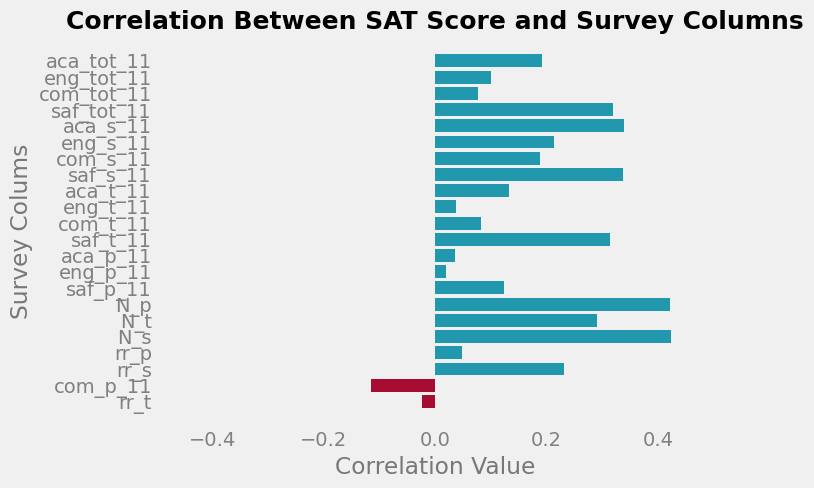

In [12]:
style.use('fivethirtyeight')

fig, ax = plt.subplots()

ax.barh(survey_corr[negative_mask].index, survey_corr[negative_mask], color='#a70d32')
ax.barh(survey_corr[positive_mask].index, survey_corr[positive_mask], color='#2198ae')

ax.grid(visible=False)

ax.set_title('Correlation Between SAT Score and Survey Columns', fontsize=18, fontweight='bold')

ax.set_xlim(-0.5,0.5)

ax.tick_params(colors='gray')

ax.set_ylabel('Survey Colums', alpha=0.5)
ax.set_xlabel('Correlation Value', alpha=0.5)

plt.show()

On the plot above we can notice that `saf_s_11` and `saf_t_11` have high correlation with SAT score. These columns measure how teachers and students perceive safety at school. Let's investigate this correlation on a scatter plot.

In [13]:
# Mask for plot
high_sat_mask = combined['sat_score'] >= 1600

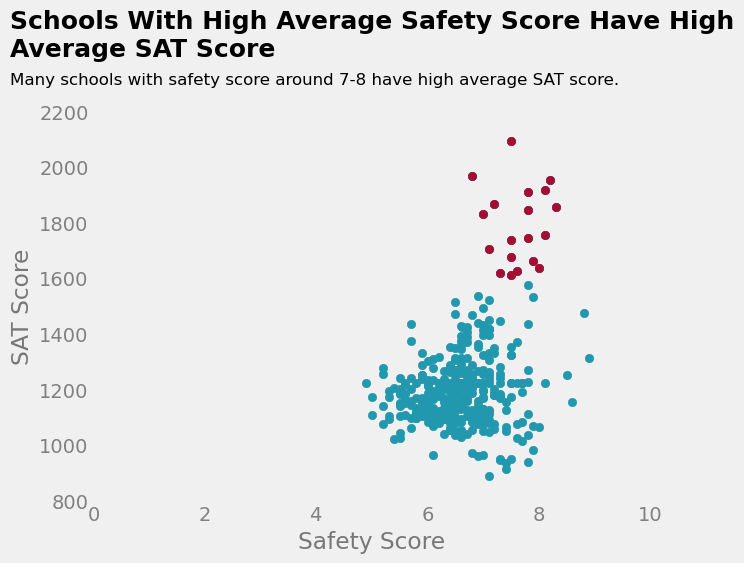

In [14]:
fig, ax = plt.subplots()

ax.scatter(combined['saf_s_11'], combined['sat_score'],
           color='#2198ae')
ax.scatter(combined.loc[high_sat_mask, 'saf_s_11'], combined.loc[high_sat_mask, 'sat_score'],
           color='#a70d32')

# Title and Sub-Title
ax.text(-1.5, 2400, 'Schools With High Average Safety Score Have High\nAverage SAT Score', fontsize=18,
        fontweight='bold')
ax.text(-1.5, 2300, 'Many schools with safety score around 7-8 have high average SAT score.',
        fontsize=12)

ax.grid(visible=False)

ax.set_xlim(0,10)
ax.set_ylim(800,2200)

ax.set_ylabel('SAT Score', alpha=0.5)
ax.set_xlabel('Safety Score', alpha=0.5)

ax.tick_params(colors='gray')

plt.show()

We can notice that the higher the safety score, the higher the average SAT score.

Let's take a look how average safety score varies based on geographic region.

In [15]:
combined.groupby('borough')[['saf_s_11', 'saf_t_11']].agg(np.mean)

,saf_s_11,saf_t_11
borough,,
Bronx,6.606577,7.026882
Brooklyn,6.370755,6.985849
Manhattan,6.831370,7.287778
Queens,6.721875,7.365625
Staten Island,6.530000,7.210000


The values do not vary much, however, we can see that high schools in the Manhattan and Queens boroughs have the highest average safety scores. Brooklyn high schools have the lowest average safety score.

## Exploring the Relationship Between SAT Scores and Various Demographic Factors

### Exploring the Relationship Between SAT Scores and Race

There are also columns that represent the percentage of races in high schools. Let's look at the correlations between these columns and SAT scores.

In [16]:
race_cols = ['white_per', 'asian_per', 'black_per', 'hispanic_per']

race_corr = combined.corr(numeric_only=True)['sat_score'][race_cols]

# Mask for plot
positive_mask = combined.corr(numeric_only=True)['sat_score'][race_cols] > 0
negative_mask = combined.corr(numeric_only=True)['sat_score'][race_cols] < 0

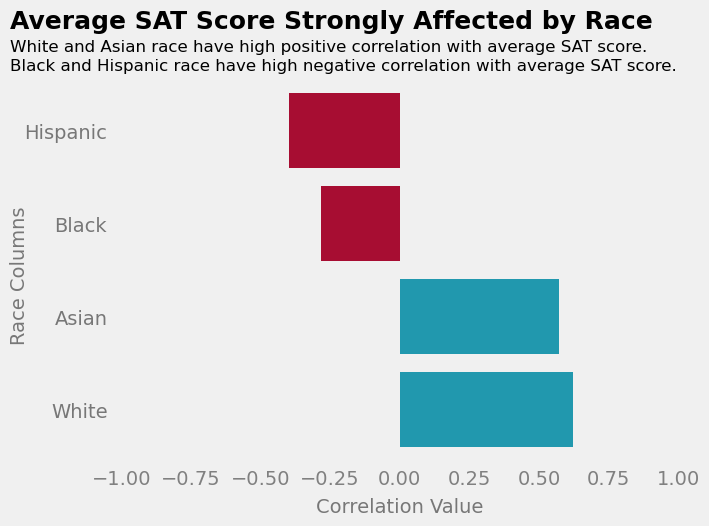

In [17]:
fig, ax = plt.subplots()

ax.barh(race_corr[positive_mask].index,race_corr[positive_mask] , color='#2198ae')
ax.barh(race_corr[negative_mask].index,race_corr[negative_mask] , color='#a70d32')

# Title and Sub-Title
ax.text(-1.4, 4.1, 'Average SAT Score Strongly Affected by Race', fontsize=18,
        fontweight='bold')
ax.text(-1.4, 3.85, 'White and Asian race have high positive correlation with average SAT score.',
        fontsize=12)
ax.text(-1.4, 3.65, 'Black and Hispanic race have high negative correlation with average SAT score.',
        fontsize=12)

ax.grid(visible=False)

ax.set_xlim(-1, 1)

ax.tick_params(axis='x', colors='gray')

# Manually place yticks
ax.set_yticks([])
ax.text(-1.253, -0.08, 'White', alpha=0.5)
ax.text(-1.238, 0.92, 'Asian', alpha=0.5)
ax.text(-1.24, 1.92, 'Black', alpha=0.5)
ax.text(-1.35, 2.92, 'Hispanic', alpha=0.5)

# yticks label
ax.text(-1.4, 0.75, 'Race Columns', rotation='vertical', fontsize=14, alpha=0.5)
# xticks label
ax.text(-0.3, -1.1, 'Correlation Value', fontsize=14, alpha=0.5)

plt.show()

By the look at this plot we can notice a high negative correlation between `hispanic_per` column and SAT score. Let's explore this on the scatter plot.

In [18]:
# Mask for plot
high_hisp_mask = combined['hispanic_per'] >= 95

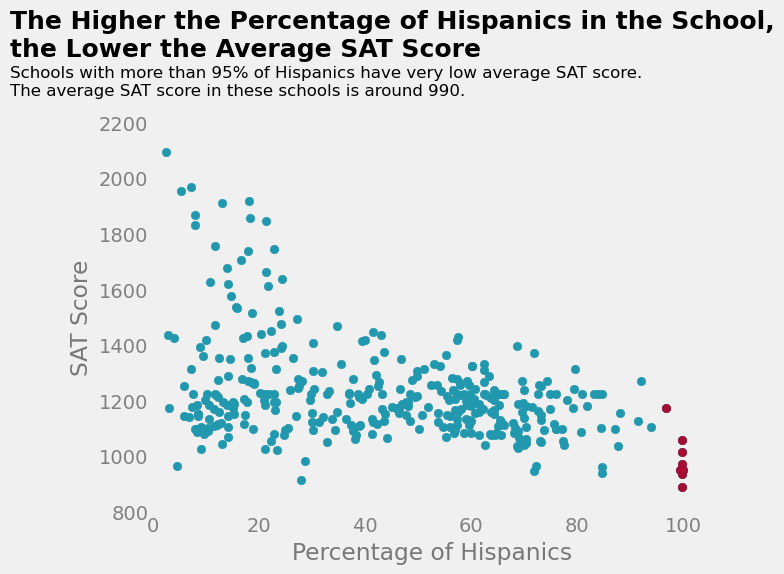

In [19]:
fig, ax = plt.subplots()

ax.scatter(combined['hispanic_per'], combined['sat_score'],
           color='#2198ae')
ax.scatter(combined.loc[high_hisp_mask, 'hispanic_per'], combined.loc[high_hisp_mask, 'sat_score'],
           color='#a70d32')

# Title and Sub-Title
ax.text(-27, 2440, 'The Higher the Percentage of Hispanics in the School,\nthe Lower the Average SAT Score', fontsize=18,
        fontweight='bold')
ax.text(-27, 2300, 'Schools with more than 95% of Hispanics have very low average SAT score.\nThe average SAT score in these schools is around 990.',
        fontsize=12)

ax.grid(visible=False)

ax.set_xlim(0,105)
ax.set_ylim(800,2200)

ax.tick_params(colors='gray')

ax.set_ylabel('SAT Score', alpha=0.5)
ax.set_xlabel('Percentage of Hispanics', alpha=0.5)

plt.show()

On the plot above we can see that the lower the percentage of Hispanics in high school, the higher the average SAT score.

Let's take a look at the high schools with the percentage of Hispanics greater than 95%.

In [20]:
combined[combined['hispanic_per'] >= 95][['SCHOOL NAME', 'sat_score', 'hispanic_per']]

,SCHOOL NAME,sat_score,hispanic_per
44,MANHATTAN BRIDGES HIGH SCHOOL,1058.0,99.8
82,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,1174.0,96.7
89,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,1014.0,99.8
125,ACADEMY FOR LANGUAGE AND TECHNOLOGY,951.0,99.4
141,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,934.0,99.8
176,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,970.0,99.8
253,MULTICULTURAL HIGH SCHOOL,887.0,99.8
286,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,951.0,100.0


The high schools listed above have a high percentage of Hispanics and a low average SAT score. These schools are primarily attended by recent immigrants to the U.S. Based on this information, we can say that there are many English learners in these schools, which can affect the average SAT score.

In [21]:
combined[(combined['hispanic_per'] <= 10) & (combined['sat_score'] >= 1800)][['SCHOOL NAME', 'sat_score', 'hispanic_per']]

,SCHOOL NAME,sat_score,hispanic_per
37,STUYVESANT HIGH SCHOOL,2096.0,2.4
151,BRONX HIGH SCHOOL OF SCIENCE,1969.0,7.2
187,BROOKLYN TECHNICAL HIGH SCHOOL,1833.0,7.9
327,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,1868.0,7.9
356,STATEN ISLAND TECHNICAL HIGH SCHOOL,1953.0,5.3


The high schools listed above are science or technology-related, and they are very difficult to enroll in. To get into these schools, you have to pass **Specialized High Schools Admissions Test** with a high score. This may explain the high average SAT score, but it does not explain the low percentage of Hispanics.

### Exploring the Relationship Between SAT Scores and Gender

We also have columns that represent gender. Let's examine the correlations between these columns and the average SAT score.

In [22]:
gender_corr = combined.corr(numeric_only=True)['sat_score'][['male_per', 'female_per']]

# Mask for plot
positive_mask = gender_corr > 0
negative_mask = gender_corr < 0

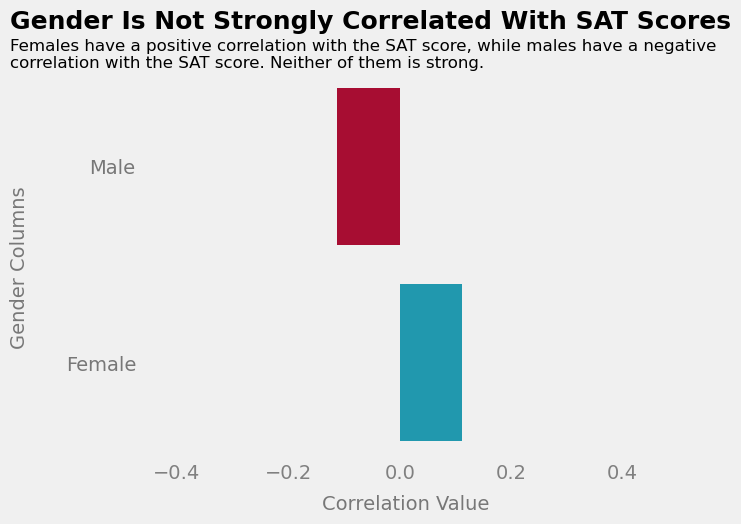

In [23]:
fig, ax = plt.subplots()

ax.barh(gender_corr[positive_mask].index, gender_corr[positive_mask], color='#2198ae')
ax.barh(gender_corr[negative_mask].index, gender_corr[negative_mask], color='#a70d32')

# Title and Sub-Title
ax.text(-0.7, 1.7, 'Gender Is Not Strongly Correlated With SAT Scores', fontsize=18,
        fontweight='bold')
ax.text(-0.7, 1.5, 'Females have a positive correlation with the SAT score, while males have a negative\ncorrelation with the SAT score. Neither of them is strong.',
        fontsize=12)

ax.grid(visible=False)

ax.set_xlim(-0.5, 0.5)
ax.tick_params(axis='x', colors='gray')

# Manually place yticks
ax.set_yticks([])
ax.text(-0.6, -0.04, 'Female', alpha=0.5)
ax.text(-0.557, 0.96, 'Male', alpha=0.5)

# yticks label
ax.text(-0.7, 0.09, 'Gender Columns', rotation='vertical', fontsize=14,
        alpha=0.5)
# xticks label
ax.text(-0.14, -0.75, 'Correlation Value', fontsize=14, alpha=0.5)

plt.show()

In the graph above, we see that a high percentage of females in schools is positively correlated with the average SAT score. On the other hand, a high percentage of males in schools is negatively correlated with the average SAT score. Neither of them is strong.

### Exploring the Relationship Between SAT Scores and Class Size

In [24]:
# Mask for plot
class_size_sat_score_mask = (combined['AVERAGE CLASS SIZE'] >= 25) & (combined['sat_score'] >= 1600)

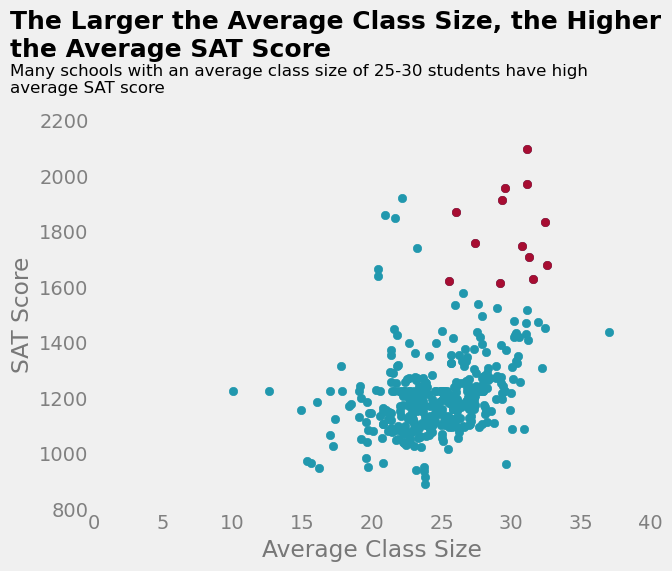

In [25]:
fig, ax = plt.subplots()

ax.scatter(combined['AVERAGE CLASS SIZE'], combined['sat_score'], color='#2198ae')
ax.scatter(combined.loc[class_size_sat_score_mask, 'AVERAGE CLASS SIZE'],
           combined.loc[class_size_sat_score_mask, 'sat_score'],
           color='#a70d32')

# Title and Sub-Title
ax.text(-6, 2430, 'The Larger the Average Class Size, the Higher\nthe Average SAT Score', fontsize=18,
        fontweight='bold')
ax.text(-6, 2300, 'Many schools with an average class size of 25-30 students have high\naverage SAT score',
        fontsize=12)

ax.grid(visible=False)

ax.set_xlim(0,40)
ax.set_ylim(800,2200)

ax.tick_params(colors='gray')

ax.set_ylabel('SAT Score', alpha=0.5)
ax.set_xlabel('Average Class Size', alpha=0.5)

plt.show()

There is a positive relationship between average SAT score and average class size. We see that schools with an average class size of about 30 students are more likely to have higher average SAT scores.

## Exploring the Relationship Between SAT Scores and the Percentage of Students Taking the AP Test

In [26]:
# Store the percentage of people who took AP test in school
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment'] * 100

# Mask for plot
ap_per_sat_score_mask = (combined['sat_score'] >= 1800) & (combined['ap_per'] >= 35)

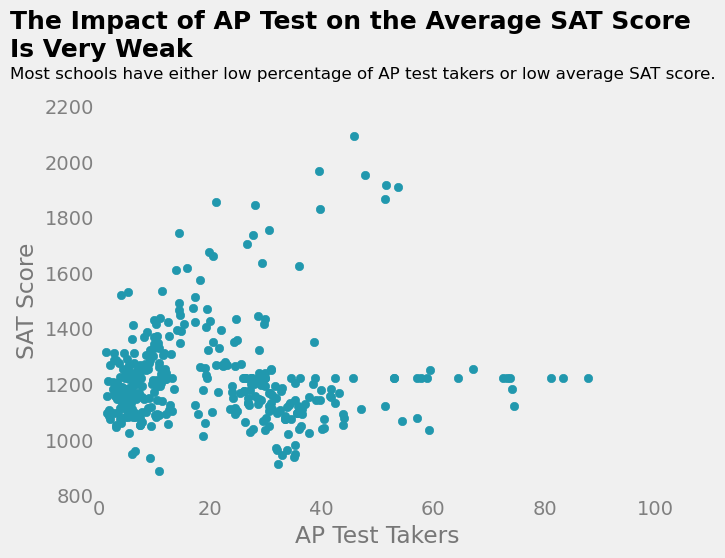

In [27]:
fig, ax = plt.subplots()

ax.scatter(combined['ap_per'], combined['sat_score'], color='#2198ae')

# Title and Sub-Title
ax.text(-16, 2380, 'The Impact of AP Test on the Average SAT Score\nIs Very Weak', fontsize=18,
        fontweight='bold')
ax.text(-16, 2300, 'Most schools have either low percentage of AP test takers or low average SAT score.',
        fontsize=12)

ax.grid(visible=False)

ax.set_xlim(0,100)
ax.set_ylim(800,2200)

ax.tick_params(colors='gray')

ax.set_ylabel('SAT Score', alpha=0.5)
ax.set_xlabel('AP Test Takers', alpha=0.5)

plt.show()

There is a very weak correlation between the percentage of students taking the AP test and the average SAT score in the chart above. Only a few schools have high average SAT scores with a percentage of AP test takers around 40-60%.

## Finding Good Schools in Each Borough

First, let's take a look at the average school rating in each borough.

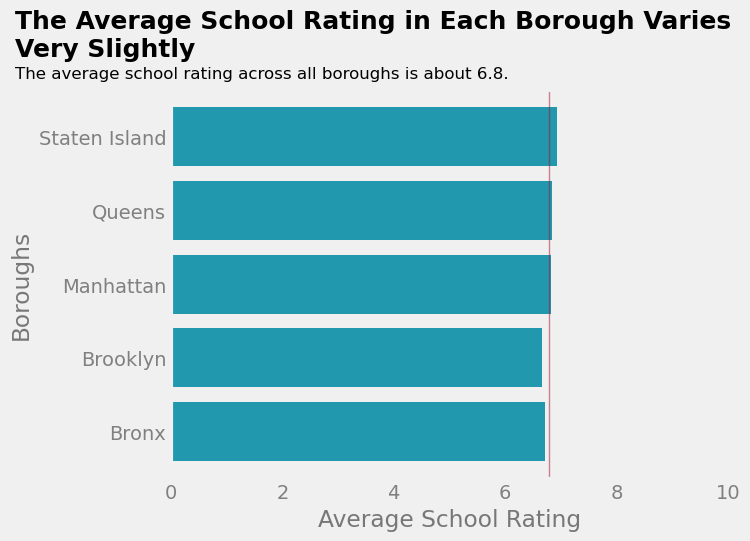

In [28]:
fig, ax = plt.subplots()

ax.barh(combined.groupby('borough')['school_rating'].agg(np.mean).index,
        combined.groupby('borough')['school_rating'].agg(np.mean),
        color='#2198ae')

# Title and Sub-Title
ax.text(-2.8, 5.1, 'The Average School Rating in Each Borough Varies\nVery Slightly', fontsize=18,
        fontweight='bold')
ax.text(-2.8, 4.8, 'The average school rating across all boroughs is about 6.8.', fontsize=12)

ax.grid(visible=False)

ax.set_xlim(0, 10)

ax.tick_params(colors='gray')

ax.set_ylabel('Boroughs', alpha=0.5)
ax.set_xlabel('Average School Rating', alpha=0.5)

# Show mean school rating across all boroughs
ax.axvline(x=6.79, color='#a70d32', alpha=0.5, linewidth=1)

plt.show()

In the chart above, we can see that the average school rating for each borough differs very slightly.

Let's see how many schools with the rating of more than 7 are in each borough.

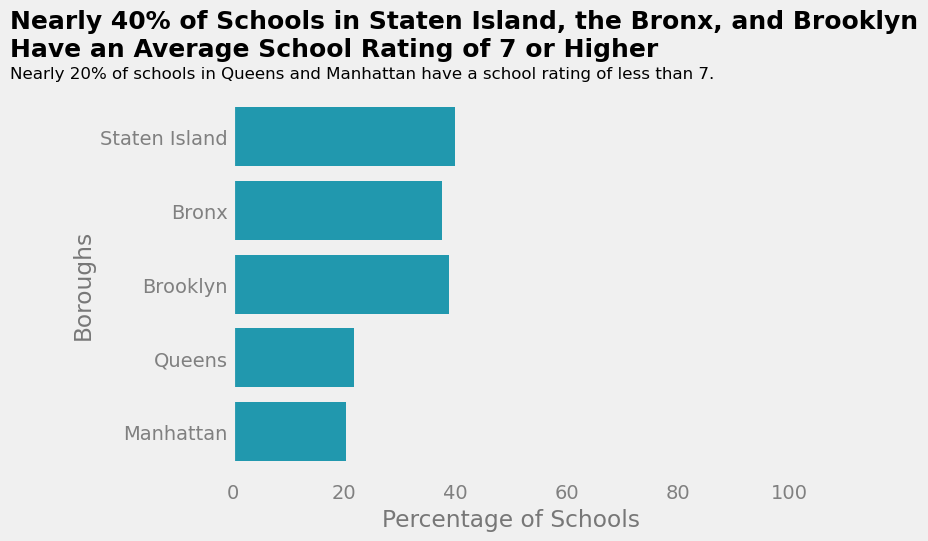

In [29]:
fig, ax = plt.subplots()

ax.barh(combined[combined['school_rating'] >= 7].value_counts('borough').index,
        combined[combined['school_rating'] >= 7].value_counts('borough') / combined.value_counts('borough') * 100,
        color='#2198ae')

# Title and Sub-Title
ax.text(-40, 5.1, 'Nearly 40% of Schools in Staten Island, the Bronx, and Brooklyn\nHave an Average School Rating of 7 or Higher', fontsize=18,
        fontweight='bold')
ax.text(-40, 4.8, 'Nearly 20% of schools in Queens and Manhattan have a school rating of less than 7.', fontsize=12)

ax.grid(visible=False)

ax.set_xlim(0, 100)

ax.tick_params(colors='gray')

ax.set_ylabel('Boroughs', alpha=0.5)
ax.set_xlabel('Percentage of Schools', alpha=0.5)

plt.show()

If we look at the percentage of schools with high ratings, we see that in Staten Island, the Bronx, and Brooklyn, about 40% of the schools have high ratings. In the boroughs of Queens and Manhattan, the percentage is about 20%.

<a id='conclusion'></a>
# Conclusion

We did a lot of hard work during this project, and here are some of the insights we got:
* The higher the safety score, the higher the average SAT scores.
* White and Asian races have a positive correlation with SAT scores, while Black and Hispanic races have a negative correlation.
* Schools, where the percentage of students taking the AP test is 40-60% have very high average SAT scores.
* Schools with an average class size of about 30 students have higher average SAT scores.
* Nearly 40% of schools in Staten Island, the Bronx, and Brooklyn have a school rating of 7 or higher.